To use this notebook, you create a DAG using Astronomer that will import objects into Weaviate.

Before using this notebook, you will need to ingest the example data located in the `include/demo_data` folder into Weaviate.To do so, set up your Astro CLI project and run the setup and ingestion DAGs as described in the README of this repository. 

Requirements:
1. Running Weaviate cluster. [Here](https://weaviate.io/developers/weaviate/installation) are the installation option,s and you can create a free sandbox [here](https://console.weaviate.cloud/).
2. [Astro CLI](https://www.astronomer.io/docs/astro/cli/install-cli)
3. [AWS S3 Bucket](https://aws.amazon.com/s3/)
4. [optional] Snowflake is only needed if you want to have the sneaker data and run the analytics portion

Recommendation: 
* Define your schema before running your DAG pipeline. If you don't do this, make sure you have the `auto-schema` enabled.

Versions: 
* weaviate-client = `4.7.1`

## Import Libraries

In [1]:
import weaviate
import weaviate.classes.config as wvcc
import weaviate.classes as wvc
from weaviate.classes.config import Property, DataType, ReferenceProperty
from weaviate.util import generate_uuid5
from weaviate.classes.init import Auth
from weaviate.classes.query import Filter


import os
import base64
from dotenv import load_dotenv, find_dotenv
import json
from PIL import Image
import matplotlib.pyplot as plt


## Connect to WCD

In [2]:
OPENAI_KEY = os.getenv('OPENAI_KEY')
headers = {"X-OpenAI-Api-Key": OPENAI_KEY}

client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv('WEAVIATE_URL'),
    auth_credentials=Auth.api_key(os.getenv('WEAVIATE_AUTH')),
    headers=headers
)

client.is_ready()

True

## Define Schema

In [4]:
# CAUTION: Only run this to reset your schema

# client.collections.delete("Products")

In [6]:
dataset = client.collections.create(
    name='Products',
    vectorizer_config=wvcc.Configure.Vectorizer.text2vec_openai(model='ada'),
    generative_config=wvcc.Configure.Generative.openai(model='gpt-4-1106-preview'),

    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="description", data_type=DataType.TEXT),
        Property(name="file_path", data_type=DataType.TEXT, skip_vectorization=True),
        Property(name="price", data_type=DataType.NUMBER, skip_vectorization=True),
        Property(name="category", data_type=DataType.TEXT)
    ]
) 

## Import Data

### The data was ingested via the DAG. Please follow the steps in the readme!

In [6]:
# count the number of objects

products = client.collections.get("Products")

products.aggregate.over_all(total_count=True)

AggregateReturn(properties={}, total_count=82)

## Query Time

### Vector Search

Vector search (or semantic search) returns the objects with most similar vectors to that of the query. Simply use the `near_text` operator to run a query.

Outdoor Adventure Boots


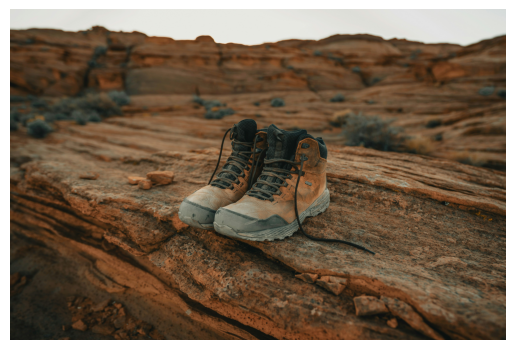

All-Terrain Hiking Boots


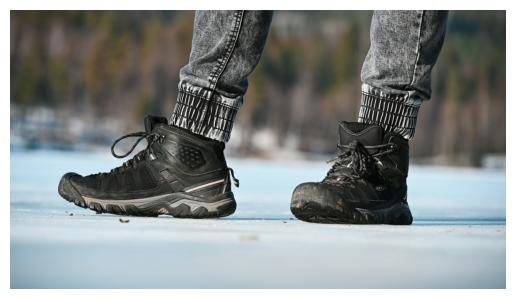

In [7]:
products = client.collections.get("Products")

response = products.query.near_text(
    query="Boots for the snow",
    return_properties=['title', 'description','file_path'],
    limit=2
)

for item in response.objects:
    print(item.properties['title'])

    image = Image.open(item.properties['file_path'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Hybrid Search

Hybrid search combines keyword and vector search. The weighting of each algorithm is determined by `alpha`. 

* `alpha` = 0 --> pure bm25
* `alpha` = 1 --> pure vector search
* `alpha` = 0.5 --> an equal weighting of vector and keyword search

All-Terrain Hiking Boots


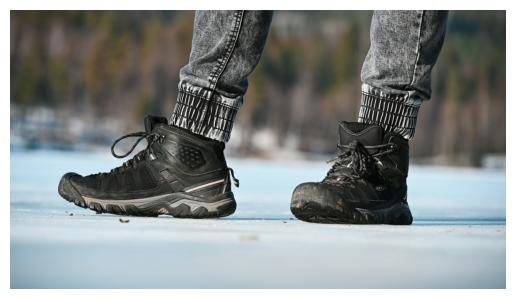

Classic Leather Hiking Boots


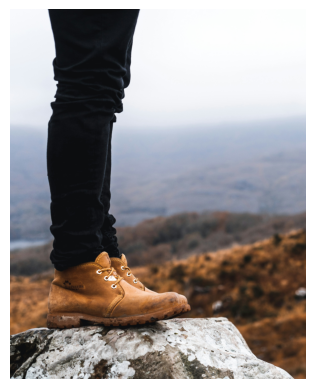

Outdoor Adventure Boots


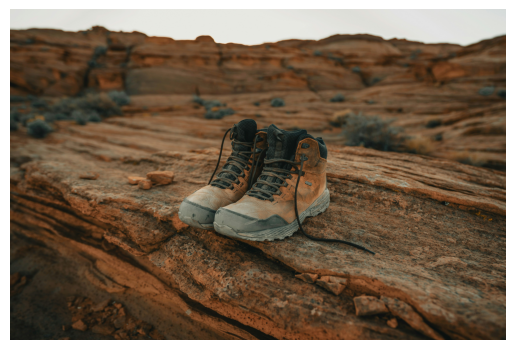

Camouflage Hiking Boots


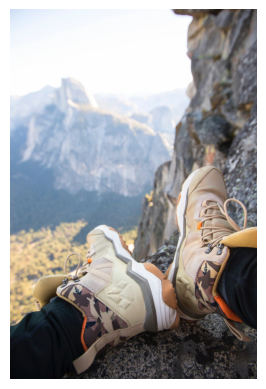

In [5]:
products = client.collections.get("Products")

response = products.query.hybrid(
    query="Boots for the snow",
    alpha=0.5,
    return_properties=['title', 'description','file_path'],
    limit=4
)

for item in response.objects:
    print(item.properties['title'])

    image = Image.open(item.properties['file_path'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Filtered Search

We can narrow down our results by adding a filter to the query.

Additionally, the below snippet shows you how to use [autocut](https://weaviate.io/developers/weaviate/api/graphql/additional-operators#autocut) (`auto_limit`). 

Rather than hard-coding the limit on the number of objects returned, we can use autocut to cut off the result set. Autocut limits the number of results returned based on significant variations in the result set's metrics, such as vector distance or score.

Urban Style Sneakers


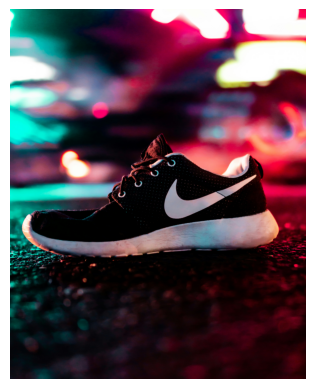

====
Urban Explorer Sneakers


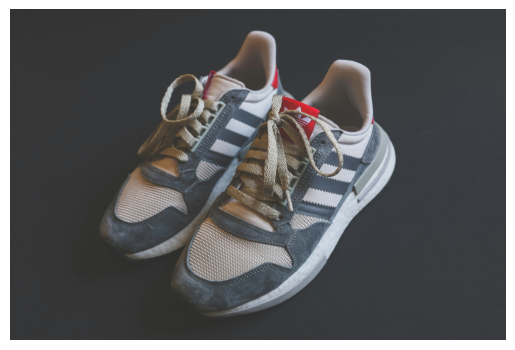

====
Modern Blue Athletic Sneakers


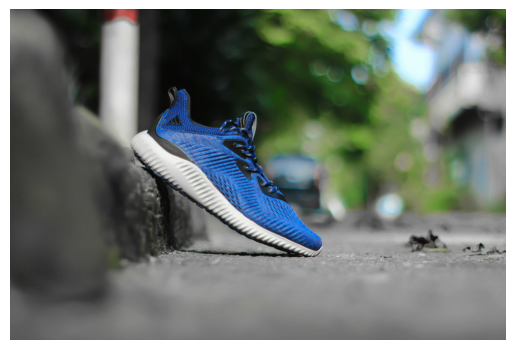

====


In [10]:
products = client.collections.get("Products")

response = products.query.near_text(
    query="lifestyle sneakers",
    return_properties=['title', 'description','file_path'],
    filters=Filter.by_property("category").equal("sneakers"),
    auto_limit=1,
)

for item in response.objects:
    print(item.properties['title'])

    image = Image.open(item.properties['file_path'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print("====")

## Generative Search

Generative Search (or RAG) searches through the database first and then passes the retrieved objects to the language model. To run a generative query, you can use the `generate.` operator.

In [20]:
task = "Compare these two lawn mowers and output which equipment is better based on your analysis."

products = client.collections.get("Products")
response = products.generate.hybrid(
    query="lawn power equipment",
    alpha=0.5,
    limit=2,
    grouped_task=task
)

print(response.generated)
print ("===")
for item in response.objects:
    print(json.dumps(item.properties['title'], indent=2))
    # print(item.generated)

    image = Image.open(item.properties['file_path'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print("====")

To compare the two lawn mowers described in the provided JSON data, we need to analyze the information given for each one and determine which might be better based on certain criteria such as power, comfort, maneuverability, and suitability for large lawns or commercial landscapes. Since the descriptions are somewhat vague and do not provide specific technical details, the comparison will be based on the information available.

Lawn Mower Tractor:
- Designed for large lawns and commercial landscapes.
- Features a comfortable seat.
- Easy-to-use controls.

Riding Lawn Mower:
- High-performance equipment for large lawns.
- Offers superior maneuverability.
- Comfortable seating arrangement.

Based on the descriptions:

For Large Lawns and Commercial Use:
- The Lawn Mower Tractor is explicitly mentioned as being designed for commercial landscapes, which may imply it is built to withstand more frequent use and possibly has a larger cutting width or more powerful engine.
- The Riding Lawn Mo

====
"Riding Lawn Mower"


====


### Another Generative Search Query

Certainly! Below is a short marketing plan for selling your Electric Weed Trimmer and Reel Lawn Mower:

**Marketing Plan for Garden Equipment**

**Executive Summary:**
This marketing plan outlines the strategy for selling two garden equipment products: the Electric Weed Trimmer and the Reel Lawn Mower. The Electric Weed Trimmer is designed for convenience and ease of use, while the Reel Lawn Mower offers an eco-friendly option for lawn maintenance. Our target market includes environmentally
====
"Electric Weed Trimmer"


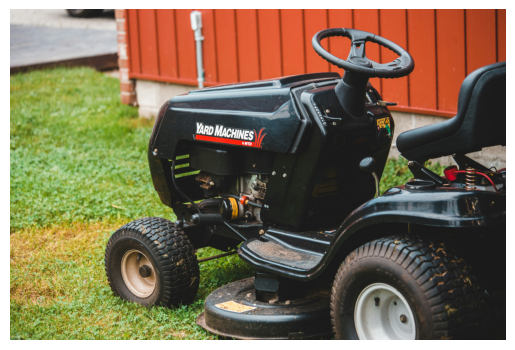

====
"Reel Lawn Mower"


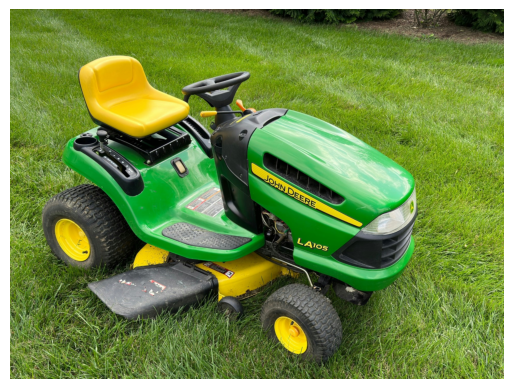

====


In [21]:
task = "Can you write a short marketing plan on how I should sell the equipment?"

products = client.collections.get("Products")
response = products.generate.near_text(
    query="cut my grass",
    limit=2,
    grouped_task=task,
    grouped_properties=["title", "description"]
)

# print the generated response
print(response.generated)
print('====')
for item in response.objects:
    print(json.dumps(item.properties['title'], indent=2))

    image = Image.open(item.properties['file_path'])
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print('====')